In [1]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *

import seaborn as sns

sns.set()


### Load data

In [2]:
path = untar_data(URLs.PETS)


In [3]:
path.ls()


(#2) [Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images')]

In [4]:
(path/"images").ls()[:4]


(#4) [Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat')]

In [5]:
(path.ls())


(#2) [Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images')]

In [6]:
(path/"images").ls()[:4]


(#4) [Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat')]

### Parse breeds names

In [7]:
fname = (path/"images").ls()[0]
fname


Path('C:/Users/Vadim/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)


['Abyssinian']

### Create dataset

In [9]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=100, min_scale=0.75))
dls = pets.dataloaders(path/"images")


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Show some images

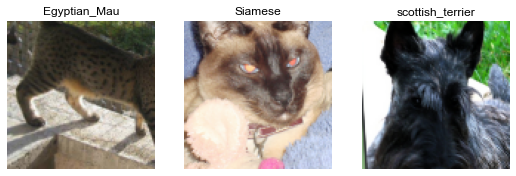

In [10]:
dls.show_batch(nrows=1, ncols=3)


### Summurazing data information

In [11]:
# pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                   get_items=get_image_files,
#                   splitter=RandomSplitter(seed=42),
#                   get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")


### Train model

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# learn.fine_tune(2)


### Let's see how the Cross-Entropy works

#### This returns the dependent and independent variables, as a mini-batch

In [13]:
x, y = dls.one_batch()


#### Let’s see what is contained in our dependent variable

In [14]:
len(y)


64

In [15]:
preds, _ = learn.get_preds(dl=[(x, y)])


In [16]:
preds[0]


TensorBase([1.4898e-05, 8.2245e-07, 9.8144e-03, 1.0269e-06, 6.6488e-07, 1.0344e-05, 1.7647e-03, 5.7451e-05, 5.9730e-05, 6.8994e-07, 1.9834e-07, 4.8775e-03, 9.5551e-02, 3.4727e-04, 1.7237e-04, 6.7138e-03,
        6.9875e-03, 3.2142e-03, 1.0642e-03, 7.2711e-07, 8.9843e-07, 2.7159e-06, 1.5183e-07, 3.5904e-03, 7.9442e-06, 3.4969e-06, 7.7064e-01, 1.6129e-09, 4.8026e-04, 3.6191e-03, 2.9502e-06, 4.3509e-06,
        6.7445e-04, 4.4155e-07, 8.5381e-05, 4.5448e-07, 9.0235e-02])

### Softmax

#### Sum should be equal 1

In [17]:
len(preds[0]), preds[0].sum()


(37, TensorBase(1.0000))

#### Sigmoid

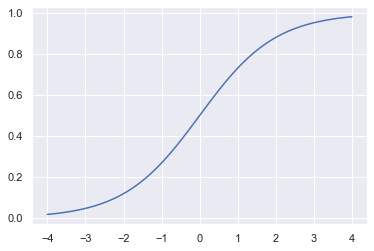

In [18]:
plot_function(torch.sigmoid, min=-4, max=4)


In [19]:
acts = torch.randn((6, 2))*2
acts


tensor([[-0.6017,  0.0406],
        [-3.3240,  0.7064],
        [-0.6294,  2.0250],
        [-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047]])

In [20]:
acts.sigmoid()


tensor([[0.3539, 0.5102],
        [0.0348, 0.6696],
        [0.3476, 0.8834],
        [0.2706, 0.0950],
        [0.5389, 0.1260],
        [0.3506, 0.7511]])

In [21]:
(acts[:, 0]-acts[:, 1]).sigmoid()


tensor([0.3447, 0.0175, 0.0657, 0.7795, 0.8902, 0.1517])

```python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [22]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts


tensor([[0.3447, 0.6553],
        [0.0175, 0.9825],
        [0.0657, 0.9343],
        [0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483]])

### Log Likelihood

In [23]:
targ = tensor([0, 1, 0, 1, 1, 0])


In [24]:
sm_acts


tensor([[0.3447, 0.6553],
        [0.0175, 0.9825],
        [0.0657, 0.9343],
        [0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483]])

In [25]:
idx = range(6)
sm_acts[idx, targ]


tensor([0.3447, 0.9825, 0.0657, 0.2205, 0.1098, 0.1517])

### NLL stands for negative log likelihood

the same as

```python
-sm_acts[idx, targ]
```

Despite its name, this PyTorch function does not take the log

In [26]:
F.nll_loss(sm_acts, targ, reduction='none')


tensor([-0.3447, -0.9825, -0.0657, -0.2205, -0.1098, -0.1517])

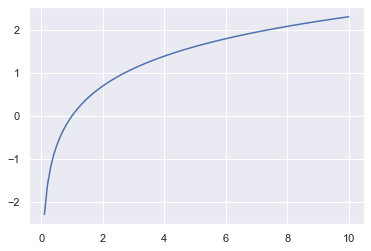

In [27]:
plot_function(torch.log, min=0, max=10)


PyTorch has a function called log_softmax that
combines log and softmax in a fast and accurate way. nll_loss is designed to be used after
log_softmax.

When we first take the softmax, and then the log likelihood of that, that combination
is called cross-entropy loss

 nn.CrossEntropyLoss which, in practice, does log_softmax and then
nll_loss

In [28]:
loss_func = nn.CrossEntropyLoss()


In [29]:
loss_func(acts, targ)


tensor(1.5686)

In [30]:
F.cross_entropy(acts, targ)


tensor(1.5686)

By default, PyTorch loss functions take the mean of the loss of all items. You can
use reduction='none' to disable that

In [31]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)


tensor([1.0650, 0.0176, 2.7224, 1.5119, 2.2091, 1.8857])

It's too hard ro read

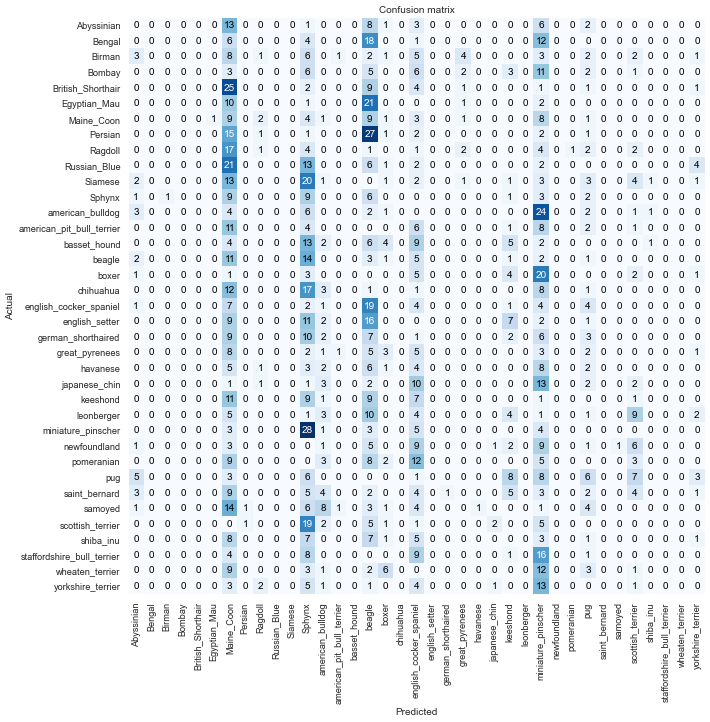

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)


But we can use another method that shows us thew worst pred

In [33]:
interp.most_confused(min_val=5)


[('miniature_pinscher', 'Sphynx', 28),
 ('Persian', 'beagle', 27),
 ('British_Shorthair', 'Maine_Coon', 25),
 ('american_bulldog', 'miniature_pinscher', 24),
 ('Egyptian_Mau', 'beagle', 21),
 ('Russian_Blue', 'Maine_Coon', 21),
 ('Siamese', 'Sphynx', 20),
 ('boxer', 'miniature_pinscher', 20),
 ('english_cocker_spaniel', 'beagle', 19),
 ('scottish_terrier', 'Sphynx', 19),
 ('Bengal', 'beagle', 18),
 ('Ragdoll', 'Maine_Coon', 17),
 ('chihuahua', 'Sphynx', 17),
 ('english_setter', 'beagle', 16),
 ('staffordshire_bull_terrier', 'miniature_pinscher', 16),
 ('Persian', 'Maine_Coon', 15),
 ('beagle', 'Sphynx', 14),
 ('samoyed', 'Maine_Coon', 14),
 ('Abyssinian', 'Maine_Coon', 13),
 ('Russian_Blue', 'Sphynx', 13),
 ('Siamese', 'Maine_Coon', 13),
 ('basset_hound', 'Sphynx', 13),
 ('japanese_chin', 'miniature_pinscher', 13),
 ('yorkshire_terrier', 'miniature_pinscher', 13),
 ('Bengal', 'miniature_pinscher', 12),
 ('chihuahua', 'Maine_Coon', 12),
 ('pomeranian', 'english_cocker_spaniel', 12),
 ('

### LR finder

In [34]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

d:\Projects\PythonProjects\DLS-Rush\venv\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.887065,5.762792,0.627199,02:58


epoch,train_loss,valid_loss,error_rate,time
0,3.030814,2.219342,0.592693,01:40


ValueError: not enough values to unpack (expected 2, got 1)

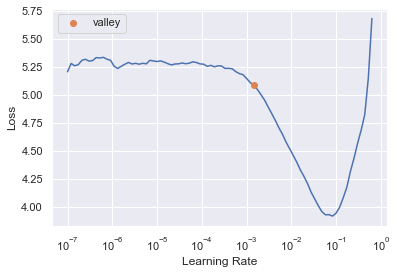

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [36]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

NameError: name 'lr_min' is not defined

In [37]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.549174,1.179806,0.349120,01:30


epoch,train_loss,valid_loss,error_rate,time
0,1.177544,0.799233,0.246955,01:45
1,0.830970,0.642297,0.201624,01:45
